# 1st week - EDA 
기본 baseline을 바탕으로 매주 모든 조원들의 EDA자료를 통합하여 제작하였습니다. 

### 데이터 명세

- id : 해당 데이터의 고유한 ID (train, test와의 중복은 없음)

- date  : 날짜

- bus_route_id : 노선 id

- in_out  : 시내버스, 시외버스 구분 (categorical)

- station_code : 해당 승하차 정류소의 ID

- station_name : 해당 승하차 정류소의 이름

- latitude : 해당 버스 정류장의 위도 

- longitude : 해당 버스 정류장의 경도 

### *** 같은 위도경도여도 진행 방향에 따라 정류장이 다를수 있음.

- X-Y ride : 00:00부터 59:59까지 승차한 인원수

- X-Y takeoff : 00:00부터 59:59까지 하차한 인원수

- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재, 예측해야할 target) 


# 0. Package & Data Load

In [26]:
#데이터 처리
import numpy as np 
import pandas as pd 
import datetime

# 결측값 유무 
import missingno as msno 

import warnings #경고 미출력
warnings.filterwarnings('ignore')
from collections import Counter # count

# 시각화
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns 

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
palette = sns.color_palette('twilight') + sns.color_palette('bright')



# 지도 관련 시각화 
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 

#model
import lightgbm as lgbm 

#processing bar
from tqdm import tqdm_notebook

In [2]:
train = pd.read_csv("버스승차예측/train.csv")
test = pd.read_csv("버스승차예측/test.csv")
weather = pd.read_csv('jeju_weather_dataset', encoding='cp949') #날씨data(외부)

# 1. EDA

##### 구조확인 

In [3]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
train.shape # 415423행 21열
test.shape # 228170행 20열

(228170, 20)

##### 통계치 확인

In [6]:
train.describe()
test.describe()

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
count,228170.000000,2.281700e+05,2.281700e+05,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.000000,228170.00000
mean,529507.500000,2.693348e+07,4.268922e+04,33.419553,126.533662,0.299268,0.786453,0.813990,0.671933,0.629101,0.619582,0.112057,0.336284,0.519503,0.452513,0.434606,0.43571
std,65867.149798,3.920495e+06,5.006822e+05,0.108004,0.141534,1.086878,2.139540,2.262655,2.046359,1.923265,2.028462,0.586951,1.271613,1.665510,1.541363,1.474626,1.53080
min,415423.000000,4.270000e+06,0.000000e+00,33.208350,126.165040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,472465.250000,2.346000e+07,3.200000e+02,33.289190,126.475160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,529507.500000,2.804000e+07,1.141000e+03,33.478330,126.529840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,586549.750000,3.003000e+07,2.236000e+03,33.499970,126.576320,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,643592.000000,3.282000e+07,6.115101e+06,33.963640,126.965670,45.000000,100.000000,106.000000,119.000000,69.000000,102.000000,37.000000,64.000000,47.000000,71.000000,55.000000,56.00000


##### train / test 컬럼 차이?

In [7]:
#train과 test의 column 차이 : 우리가 구해야할 타겟 18~20_ride
set(train.columns)-set(test.columns)

{'18~20_ride'}

##### 날짜 범위가 겹치지 않음을 확인. 

In [8]:
# train / test 날짜 범위 비교
train['date'].agg(['min','max']) #2019-09-01 ~ 2019-09-30 (train)
test['date'].agg(['min','max']) #2019-10-01 ~ 2019-10-16 (test)

min    2019-10-01
max    2019-10-16
Name: date, dtype: object

##### 결측값 확인 : 없음.

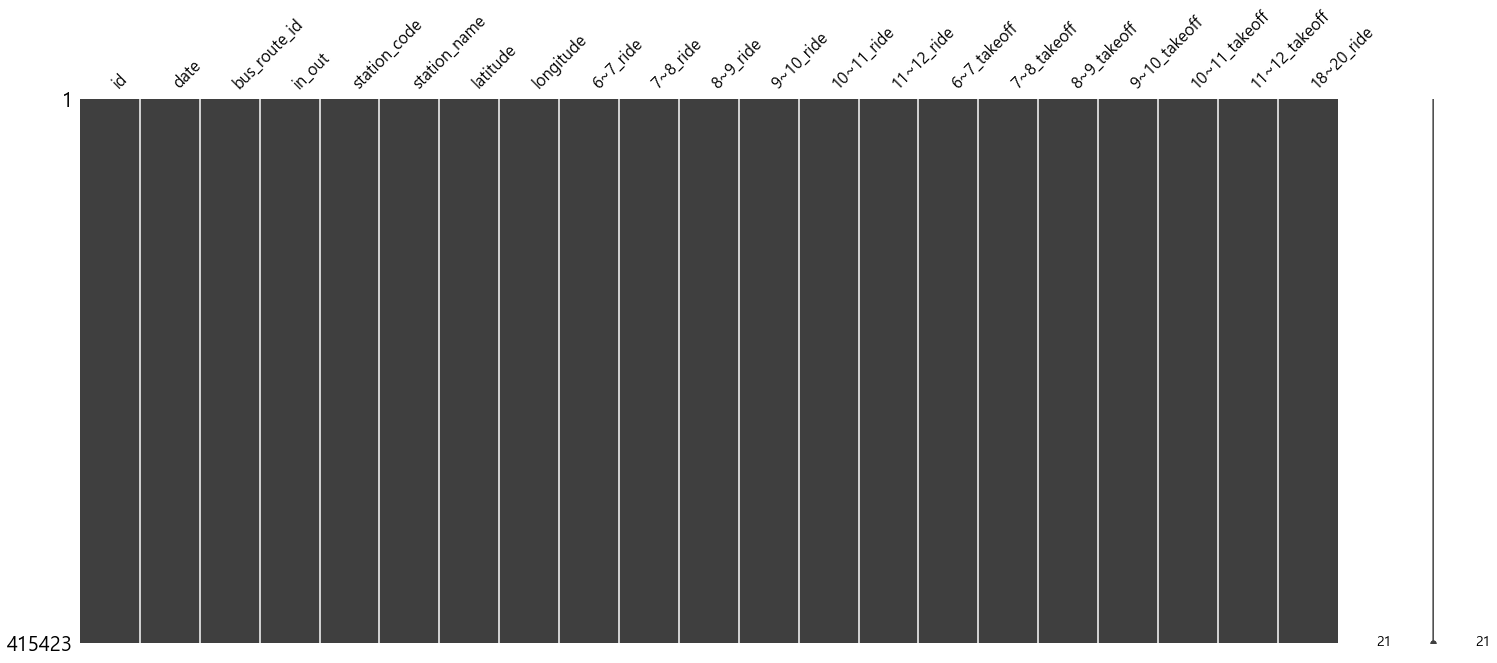

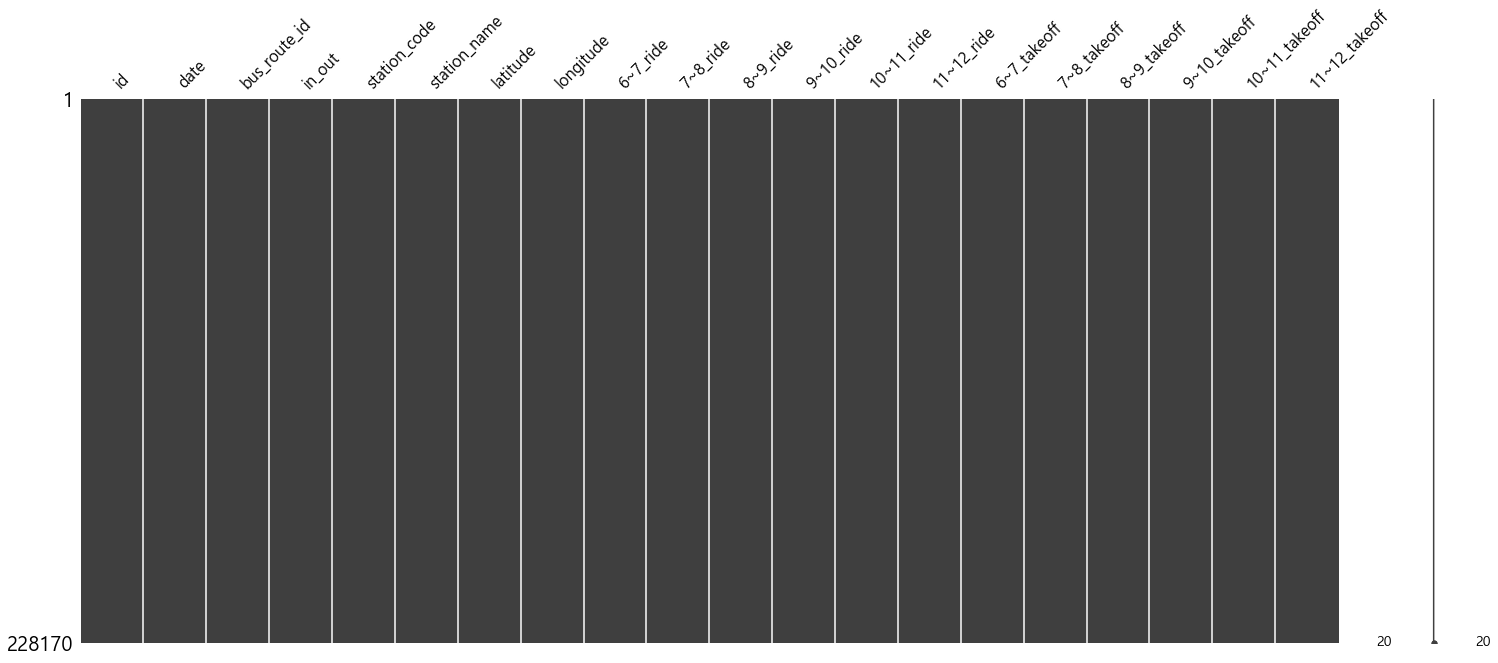

In [9]:
#train에 이상값 있나? #없음.
msno.matrix(train)
msno.matrix(test)

In [10]:
#한번 더 확인
print(train.isnull().sum())#train 결측값 개수 확인 
print("-----------------------------")
print(test.isnull().sum()) #train 결측값 개수 확인 

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64
-----------------------------
id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64


##### 특이점 1. target인 18~20ride분포가 대부분 0이다.

- 날짜의 갯수가 날 마다 다른것을 보았을때 승차인원이 없거나하면 표기가 안된다? Yes.
- 6시~12시 내린 승객이 한명도 없고, 탄 승객이 없을 경우 해당 로우 삭제한다? Yes.
- 특정날짜, 루트에도 없다? => 승차 하차 승객 0 일 수 있기 때문에 0이라는 피쳐 추가 가능할것.


- Dacon 데이터 설명 중..
- 버스에서 하차를 할 때, 버스카드를 찍지 않는 경우, 해당 기록이 비어 있는 상태입니다. 
- 따라서, 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이가 있음을 미리 알려드립니다.

In [11]:
target_col = '18~20_ride'
train[target_col].value_counts().sort_index() #0의 분포가 압도적으로 많음.

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
          ...  
240.0         1
241.0         1
245.0         1
265.0         1
272.0         1
Name: 18~20_ride, Length: 170, dtype: int64

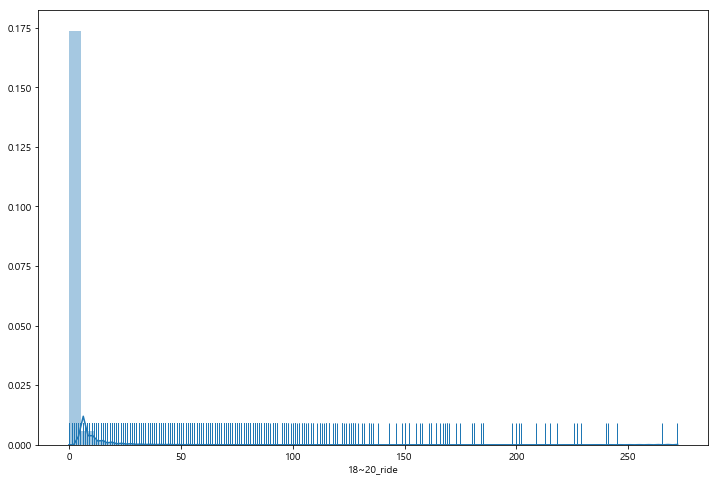

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col], rug=True) #0의 분포가 매우 높음.(시각화로 한번 더 확인.)

In [13]:
# 탑승 columns, 하차 columns
ride_columns = [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col] 

# Train의 승차 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min','max']) )

# Train의 하차 칼럼들의 rowsum
display( train[train[target_col]==0][take_off_columns].sum(axis=1).agg(['min','max']) )

# Train의 승하차 합 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns + take_off_columns].sum(axis=1).agg(['min','max']) )  

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

##### 특이점 2. Station_name과 code가 1:1 맵핑을 이루지 않는다.

* 정류장 코드, 정류장 좌표는 1:1 매핑
* 정류장 이름은 여러 정류장 코드를 가짐
* 정류장 이름은 여러 정류장 좌표를 가짐

* 결론 : 정류장 이름은 대표성을 갖지 않음.

In [14]:
#하나의 station name에 다수의 station_code 발견.
multi_station = train.groupby('station_name')['station_code'].nunique().sort_values()
multi_station[multi_station >= 7]

station_name
금악리    7
신안동    8
Name: station_code, dtype: int64

In [15]:
train[train['station_name'].isin(multi_station.index)][['station_code', 'station_name', 'latitude', 'longitude']]

#결국, station_code가 고유값임을 확인. 고유 정류장 기준을 station_name으로 설정하기에는 어려움.

,station_code,station_name,latitude,longitude
0,344,제주썬호텔,33.48990,126.49373
1,357,한라병원,33.48944,126.48508
2,432,정존마을,33.48181,126.47352
3,1579,제주국제공항(600번),33.50577,126.49252
4,1646,중문관광단지입구,33.25579,126.41260
...,...,...,...,...
415418,1129,한림환승정류장(한림리),33.41437,126.26336
415419,1564,제주시외버스터미널,33.49946,126.51479
415420,2322,해병부대,33.23100,126.26273
415421,3291,애월환승정류장(애월리),33.46483,126.31870


In [16]:
len(train['station_code'].unique()), len(train['station_name'].unique())

(3563, 1961)

##### 특이점3. 버스 수요가 요일에 영향을 미치는가.

* 7일주기로 승하차량이 급감하는 것을 알 수 있음
* 요일이 승하차량에 영향을 미치는 것이라 추정 -> 요일 파생변수 생성
* 요일이 승하차량에 영향을 미친다면 공휴일도 영향을 미칠 것이라 추정 -> 공휴일 정보 생성

In [17]:
ride_col_list = ['%d~%d_ride'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']
takeoff_col_list = ['%d~%d_takeoff'%(i, i+1) for i in range(6, 12)] + ['18~20_ride']

In [18]:
df_date_ride = train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns = ['date', 'ride_time', 'count']
df_date_ride['date_disp'] = df_date_ride['date'].apply(lambda x: x[5:])


df_date_takeoff = train.groupby(['date']).sum()[takeoff_col_list].stack().reset_index()
df_date_takeoff.columns = ['date', 'takeoff_time', 'count']
df_date_takeoff['date_disp'] = df_date_takeoff['date'].apply(lambda x: x[5:])
df_date_takeoff.head(5)

,date,takeoff_time,count,date_disp
0,2019-09-01,6~7_takeoff,1343.0,09-01
1,2019-09-01,7~8_takeoff,2713.0,09-01
2,2019-09-01,8~9_takeoff,3671.0,09-01
3,2019-09-01,9~10_takeoff,4077.0,09-01
4,2019-09-01,10~11_takeoff,4510.0,09-01


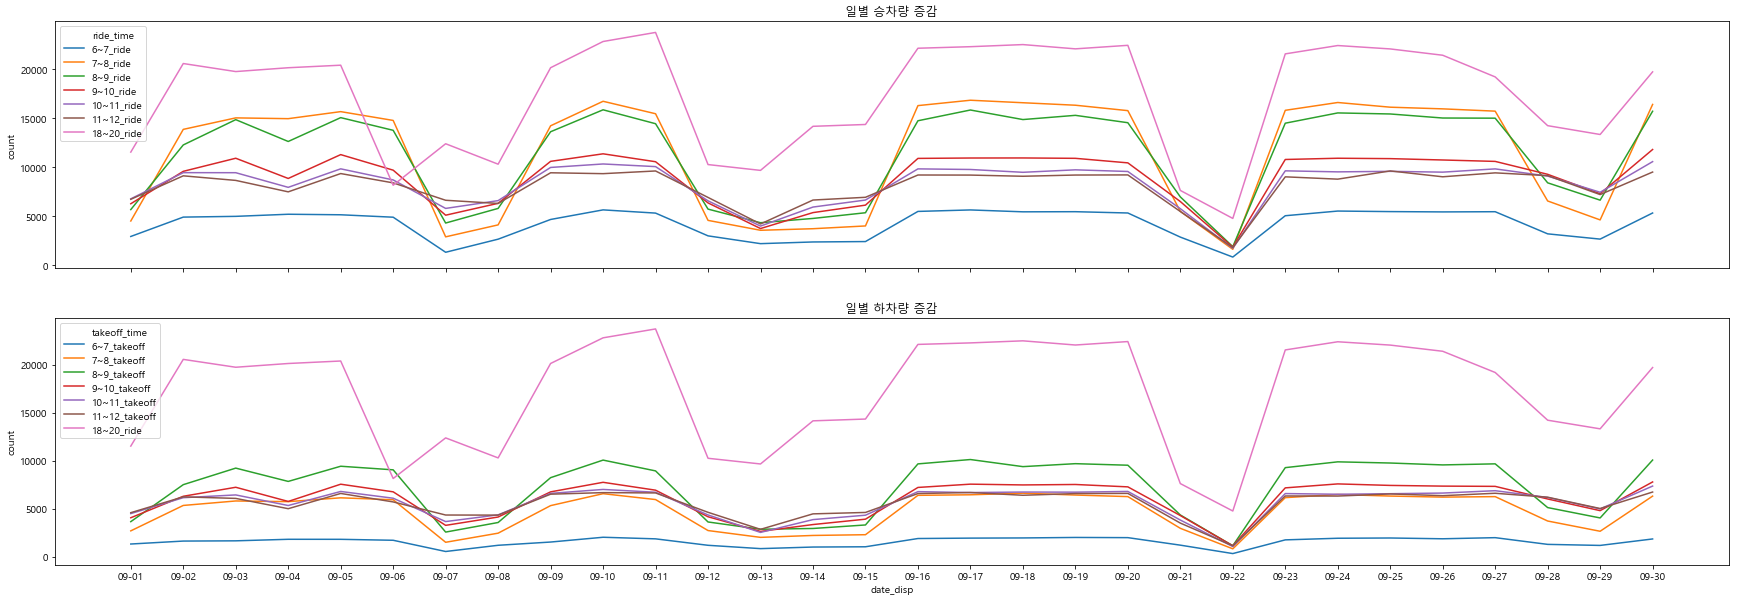

In [19]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

axes[0].set(title='일별 승차량 증감')
sns.lineplot(x='date_disp', y='count', hue='ride_time', data=df_date_ride, ax=axes[0])

axes[1].set(title='일별 하차량 증감')
sns.lineplot(x='date_disp', y='count', hue='takeoff_time', data=df_date_takeoff, ax=axes[1])

In [20]:
holidays = ['01-01', '02-04', '02-05', '02-06', '03-01', '05-05', '05-06', '05-12', '06-06', '08-15',
            '09-12', '09-13', '09-14', '10-03', '10-09', '12-25']
holidays = ['2019-'+day for day in holidays]

train['weekday'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%A"))
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in ['Saturday', 'Sunday'] else row.holiweekend, axis=1)

In [21]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_week_ride = train.groupby(['weekday']).mean()[ride_col_list[:-1]].stack().reset_index()
df_week_ride.columns = ['weekday', 'ride_time', 'count']

df_week_takeoff = train.groupby(['weekday']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_week_takeoff.columns = ['weekday', 'takeoff_time', 'count']

df_week_ride['order'] = df_week_ride['weekday'].apply(lambda x: weekday_order.index(x))
df_week_ride=df_week_ride.sort_values(by=['order'])

df_week_takeoff['order'] = df_week_takeoff['weekday'].apply(lambda x: weekday_order.index(x))
df_week_takeoff=df_week_takeoff.sort_values(by=['order'])

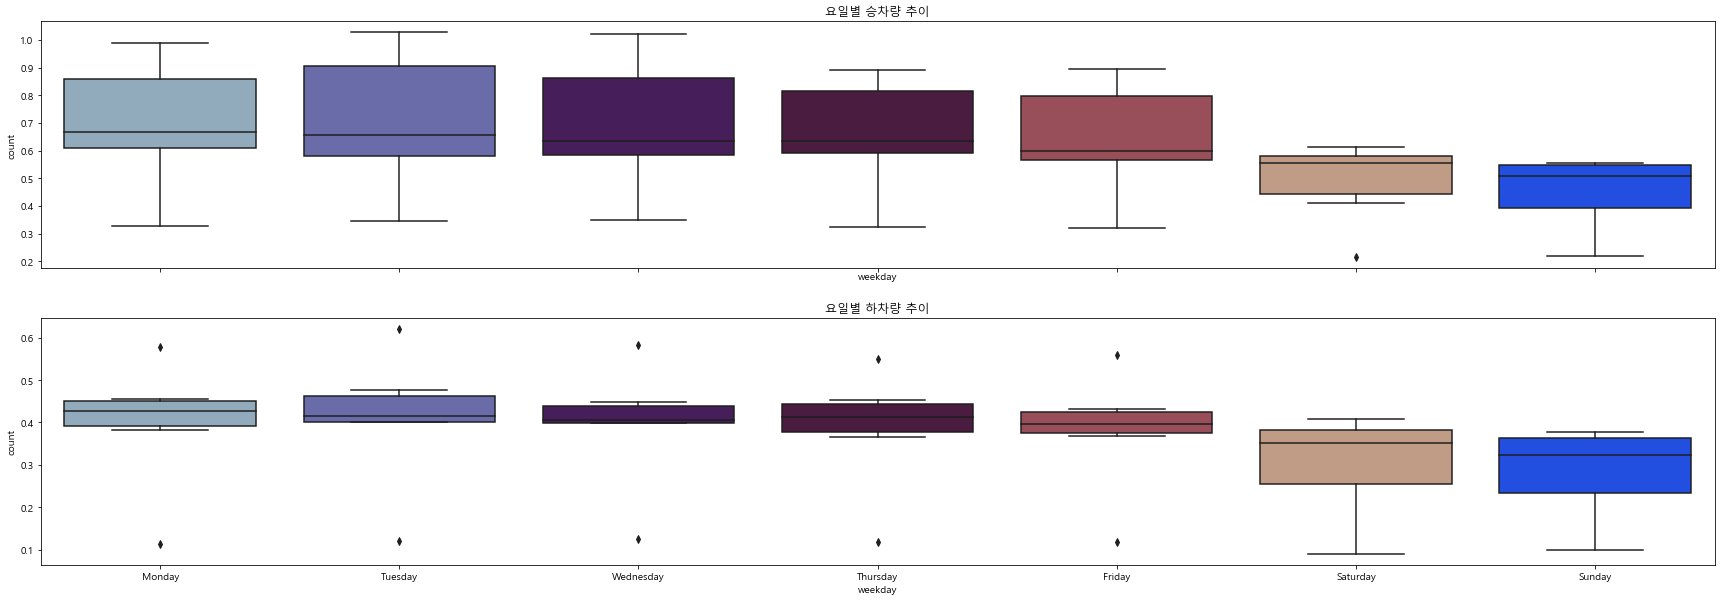

In [22]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)


axes[0].set(title='요일별 승차량 추이')
axes[1].set(title='요일별 하차량 추이')

sns.boxplot(x='weekday', y='count', data=df_week_ride, ax=axes[0], palette=palette)
sns.boxplot(x='weekday', y='count', data=df_week_takeoff, ax=axes[1], palette=palette)

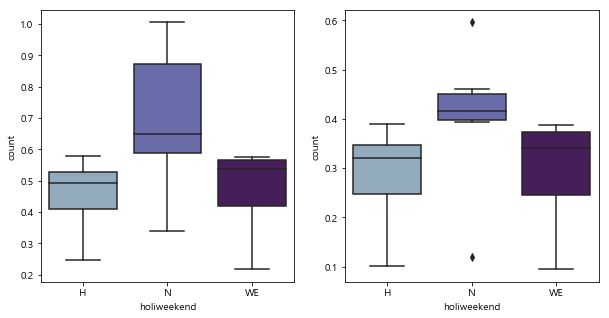

In [23]:
#평일, 휴일 승하차량 비교

f, axes = plt.subplots(1, 2, figsize=(10, 5))

df_holi_ride = train.groupby(['holiweekend']).mean()[ride_col_list[:-1]].stack().reset_index()
df_holi_ride.columns = ['holiweekend', 'ride_time', 'count']

df_holi_takeoff = train.groupby(['holiweekend']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_holi_takeoff.columns = ['holiweekend', 'ride_time', 'count']

sns.boxplot(x='holiweekend', y='count', data=df_holi_ride, ax=axes[0], palette=palette)
sns.boxplot(x='holiweekend', y='count', data=df_holi_takeoff, ax=axes[1], palette=palette)

##### 특이점 4. 주요 측정소

In [24]:
# 해당 주요 장소의 임의 지역 위도, 경도 (baseline 참조)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [25]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm